In [1]:
import os
import numpy as np
import argparse
import json
import logging
import time
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Bernoulli

import torchvision
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter  # TensorBoard

import algorithms.vae.model as vae_model
from algorithms.vae.gridworld_dataset import GridworldDataset
from algorithms.vae.pong_dataset import PongDataset

import sys

In [3]:
parser = argparse.ArgumentParser(description='VAE MNIST')
parser.add_argument('-f')
parser.add_argument('--log_root', default='algorithms/runs/', help='directory to store logs')
parser.add_argument('--data_root', default='algorithms/data/', help='directory to store the dataset')
parser.add_argument('--dataset', default='mnist', help='dataset')
parser.add_argument('--batch-size', type=int, default=64, help='input batch size (default: 64)')
parser.add_argument('--epochs', type=int, default=10, help='number of epochs (default: 100)')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate (default: 1e-3)')
parser.add_argument('--latent_dim', type=int, default=10, help='latent dimension (default: 10)')
parser.add_argument('--beta', type=float, default=1, help='beta for beta-VAE (default: 1) = basic VAE')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
parser.add_argument('--log_interval', type=int, default=100, help='logging frequency measured by number of training episodes')
parser.add_argument('--no-cuda', action='store_true', default=False, help='enables CUDA')
parser.add_argument('--log_elbo', action='store_true', default=False, help='stores elbo for each input into log file')
parser.add_argument('--eval_set', type=str, default='not_in_training', help='name of the evaluation set')
parser.add_argument('--eval', action='store_true', default=False, help='run only evaluation')
parser.add_argument('--comment', default='', help='additional comment to the run')

args = parser.parse_args("""--epochs=200 --beta=0.1 --dataset=gridworld --log_interval=100 --latent_dim=5
                         --lr=0.01 --comment='7x7'""".split()
)

# if gpu is to be used
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

torch.manual_seed(args.seed)
np.random.seed(args.seed)

In [4]:
args.data_root

'algorithms/data/'

In [5]:
if args.dataset == 'mnist':
	train_set = datasets.MNIST(root=args.data_root, train=True, transform=transforms.ToTensor(), download=True)
	test_set = datasets.MNIST(root=args.data_root, train=False, transform=transforms.ToTensor(), download=True)
	img_size = (28, 28)
	in_channels = 1
elif args.dataset == 'fashionmnist':
	train_set = datasets.FashionMNIST(root=args.data_root+args.dataset, train=True, transform=transforms.ToTensor(), download=True)
	test_set = datasets.FashionMNIST(root=args.data_root+args.dataset, train=False, transform=transforms.ToTensor(), download=True)
	img_size = (28, 28)
	in_channels = 1
elif args.dataset == 'gridworld':
	# data_dir = f"{args.data_root}Gridworlds/2019-10-12-22:25:11"
	# data_dir = f"{args.data_root}Gridworlds/841-images"
	data_dir = f"{args.data_root}Gridworlds/moving_water/7x7"
	if args.eval:
		train_csv_file = f"{data_dir}/{args.eval_set}.csv"
		test_csv_file = f"{data_dir}/{args.eval_set}.csv"
		# train_csv_file = f"{data_dir}/test_states.csv"
		# test_csv_file = f"{data_dir}/test_states.csv"
		train_images_dir = f"{data_dir}/testset/"
		test_images_dir = f"{data_dir}/testset/"
	else:
		# train_csv_file = f"{data_dir}/state-action-catastrophe.csv"
		# test_csv_file = f"{data_dir}/test_states.csv"
		# train_images_dir = f"{data_dir}/states/"
		# test_images_dir = f"{data_dir}/testset/"
		train_csv_file = f"{data_dir}/train_set.csv"
		test_csv_file = f"{data_dir}/dev_set.csv"
		train_images_dir = f"{data_dir}/states/"
		test_images_dir = f"{data_dir}/states/"
	gridworld_train_set = GridworldDataset(csv_file=train_csv_file, images_dir=train_images_dir, transform=transforms.ToTensor())
	gridworld_test_set = GridworldDataset(csv_file=test_csv_file, images_dir=test_images_dir, transform=transforms.ToTensor())
	img_size = (7, 7)
	in_channels = 3
elif args.dataset == 'pong':
	print(args.data_root)
	csv_file = f"{args.data_root}/state-action-catastrophe_labeled.csv"
	images_dir = f"{args.data_root}/states/"
	pong_dataset = PongDataset(csv_file=csv_file, images_dir=images_dir, transform=transforms.ToTensor(), classes=['none'])
	img_size = (80, 90)
	in_channels = 1
else:
	raise NotImplementedError

if args.dataset == 'gridworld':
	train_loader = torch.utils.data.DataLoader(dataset=gridworld_train_set, batch_size=args.batch_size, pin_memory=args.cuda, shuffle=True)
	test_loader = torch.utils.data.DataLoader(dataset=gridworld_test_set, batch_size=args.batch_size, pin_memory=args.cuda, shuffle=True)
elif args.dataset == 'pong':
	train_loader = torch.utils.data.DataLoader(dataset=pong_dataset, batch_size=args.batch_size, pin_memory=args.cuda, shuffle=True)
	test_loader = torch.utils.data.DataLoader(dataset=pong_dataset, batch_size=args.batch_size, pin_memory=args.cuda, shuffle=True)
	# print(pong_dataset.pong_df.head())
	# print(pong_dataset.pong_df.shape)
	# x, _ = next(iter(test_loader))
	# in_grid = torchvision.utils.make_grid(x.view(-1, in_channels, img_size[1], img_size[0]).cpu())
	# npimg = in_grid.numpy()
	# print(x.shape)
	# print(x.view(-1, in_channels, img_size[1], img_size[0]).shape)
	# print(in_grid.shape)
	# plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
	# plt.show()
	# print('sleeping')
	# time.sleep(100)
	# print('not sleeping')
else:
	from torch.utils.data.sampler import SubsetRandomSampler
	subset_indices = range(1000)
	train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=args.batch_size, pin_memory=args.cuda, sampler=SubsetRandomSampler(subset_indices))
	test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=args.batch_size, pin_memory=args.cuda, sampler=SubsetRandomSampler(subset_indices))
	# train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=args.batch_size, pin_memory=args.cuda, shuffle=True)
	# test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=args.batch_size, pin_memory=args.cuda, shuffle=True)


In [6]:
encoder = vae_model.MLPEncoderOne(args.latent_dim, img_size).to(device)
decoder = vae_model.MLPDecoderOne(args.latent_dim, img_size).to(device)
# encoder = vae_model.MLPEncoder(args.latent_dim, img_size).to(device)
# decoder = vae_model.MLPDecoder(args.latent_dim, img_size).to(device)
# encoder = vae_model.EncoderPong(args.latent_dim).to(device)
# decoder = vae_model.DecoderPong(args.latent_dim).to(device)
# encoder = vae_model.Encoder(args.latent_dim).to(device)
# decoder = vae_model.Decoder(args.latent_dim).to(device)
vae = vae_model.VAE(encoder, decoder).to(device)

In [7]:
def test(epoch, test_loader):
	vae.eval()
	batch_loss = []
	epoch_elbos = []

	test_loss = 0.0
	with torch.no_grad():
		for i, (x, _) in enumerate(test_loader):
			x = x.to(device)
			out = vae(x)
			loss, kl, elbo_batch = loss_function(x=x, beta=args.beta, **out)
			batch_loss.append(loss.item())
			test_loss += loss.item()
			epoch_elbos.extend(elbo_batch.cpu().detach().numpy().flatten())  # store the elbo for each input datapoint into a list
# 			if i == 0 and not args.eval:
				# Record input images
# 				in_grid = torchvision.utils.make_grid(x.view(-1, in_channels, img_size[1], img_size[0]).cpu())
# 				valid_writer.add_image('input images', in_grid)

				# Record reconstructed images
# 				out_grid = torchvision.utils.make_grid(out['z_mu'].view(-1, in_channels, img_size[1], img_size[0]).cpu())
# 				valid_writer.add_image('reconstructions', out_grid)

	# test_loss /= len(test_loader.dataset)
	# print('====> Test set loss: {:.4f}'.format(test_loss))

	if args.log_elbo:
		epoch_elbos

	return np.mean(batch_loss), epoch_elbos


def save_model(model, log_dir):
    pth = os.path.join(log_dir, f"{args.dataset}_b{args.beta}_z{args.latent_dim}_ep{args.epochs}_model.pth")
    torch.save(model.state_dict(), pth)

def load_model(model, log_dir):
    model.load_state_dict(torch.load(
        os.path.join(log_dir, f"{args.dataset}_b{args.beta}_z{args.latent_dim}_ep{args.epochs}_model.pth"))
                         )

In [8]:
def ELBO_loss(x, z, q_zx, p_xz, p_z, beta, **kwargs):
	x = x.view(x.shape[0], -1)
	# print(x.shape)
	log_prob_p_xz = p_xz.log_prob(x).sum(dim=1)
	log_prob_p_z = p_z.log_prob(z).sum(dim=1)
	log_prob_q_zx = q_zx.log_prob(z).sum(dim=1)
	elbo_batch = log_prob_p_xz + beta*(log_prob_p_z - log_prob_q_zx)
	loss = -torch.mean(elbo_batch)
	kl = torch.mean(beta*(log_prob_p_z - log_prob_q_zx))
#     print(loss, torch.mean(log_prob_p_xz).item(), torch.mean(log_prob_p_z).item(), torch.mean(log_prob_q_zx).item())
	return loss, kl, elbo_batch


loss_function = ELBO_loss
optimizer = optim.Adam(vae.parameters(), lr=args.lr)

In [9]:
# load_model(vae, '/home/lukas/Workspaces/DTU/deep-rl-thesis/algorithms/runs/gridworld-10-epochs10-beta1-seed1-MLP-color-2019-15-12-16:27:20')
# load_model(vae, '/home/lukas/Workspaces/DTU/deep-rl-thesis/algorithms/trained_models/gridworld/7x7')
load_model(vae, '/home/lukas/Workspaces/DTU/deep-rl-thesis/algorithms/trained_models/gridworld/7x7/bn')
vae.eval()
_, epoch_elbos = test(0, test_loader)
"""
# print(epoch_elbos)
eval_logger = logging.getLogger(f'{args.dataset}_epochs{args.epochs}_beta{args.beta}_test - {args.eval_set}')
eval_logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler(f'eval_epoch_elbos.log')
fh.setLevel(logging.DEBUG)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
# add the handlers to the logger
eval_logger.addHandler(fh)
eval_logger.info(epoch_elbos)
"""

"\n# print(epoch_elbos)\neval_logger = logging.getLogger(f'{args.dataset}_epochs{args.epochs}_beta{args.beta}_test - {args.eval_set}')\neval_logger.setLevel(logging.DEBUG)\n# create file handler which logs even debug messages\nfh = logging.FileHandler(f'eval_epoch_elbos.log')\nfh.setLevel(logging.DEBUG)\n# create formatter and add it to the handlers\nformatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')\nfh.setFormatter(formatter)\n# add the handlers to the logger\neval_logger.addHandler(fh)\neval_logger.info(epoch_elbos)\n"

In [238]:
for i, (x, _) in enumerate(test_loader):
    x = x.to(device)
    out = vae(x)
    loss, kl, elbo_batch = loss_function(x=x, beta=args.beta, **out)
    
    in_grid = torchvision.utils.make_grid(x.view(-1, in_channels, img_size[1], img_size[0]).cpu())
    break

In [10]:
x_train, _ = next(iter(train_loader))
x_train.shape

torch.Size([64, 3, 7, 7])

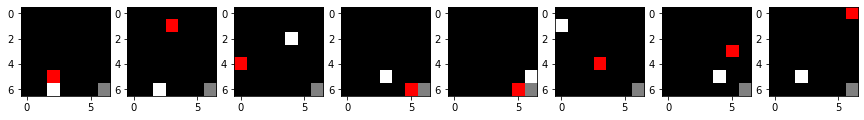

In [201]:
my_num = 3
in_grid.shape
img = np.transpose(x[0], (1,2,0))
img.shape
fig, ax = plt.subplots(ncols=8, figsize=(15,5))
for i, x_i in enumerate(range(my_num*8, (my_num+1)*8)):
    img = np.transpose(x_train[x_i], (1,2,0))
    ax[i].imshow(img)
plt.show()

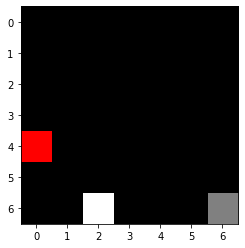

In [169]:
# a02_w35 = np.transpose(x_train[41], (1,2,0)) ##
# a02_w30 = np.transpose(x_train[47], (1,2,0)) ##
# a62_w04 = np.transpose(x_train[51], (1,2,0)) ###
# a03_w11 = np.transpose(x_train[56], (1,2,0)) #
# a03_w32 = np.transpose(x_train[33], (1,2,0)) #
# a03_w06 = np.transpose(x_train[37], (1,2,0)) #
# a03_w34 = np.transpose(x_train[51], (1,2,0)) #
img = np.transpose(x_train[26], (1,2,0))
plt.imshow(img)
plt.show()

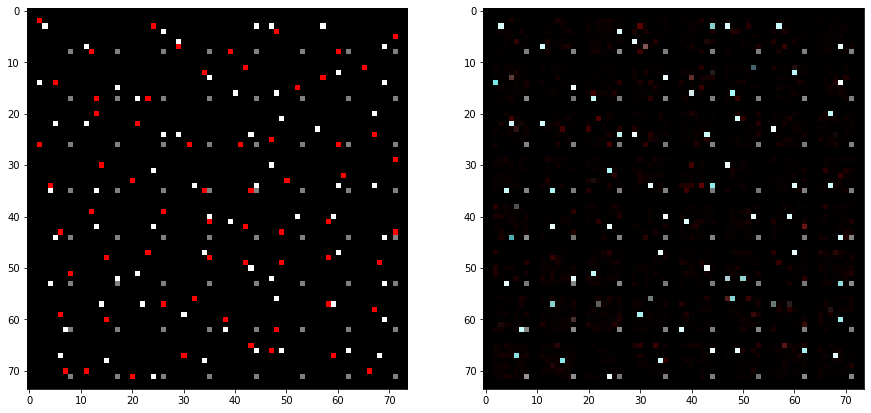

In [221]:
vae.eval()
with torch.no_grad():
    out_recon = vae(x_train.to(device))
    in_grid = torchvision.utils.make_grid(x_train.view(-1, in_channels, img_size[1], img_size[0]).cpu())
    out_grid = torchvision.utils.make_grid(out_recon['z_mu'].view(-1, in_channels, img_size[1], img_size[0]).cpu())

fig, ax = plt.subplots(ncols=2, figsize=(15,8))
ax[0].imshow(np.transpose(in_grid, (1,2,0)))
ax[1].imshow(np.transpose(out_grid, (1,2,0)))
plt.show()

In [227]:
np.iinfo(np.int32).max

2147483647

xavier


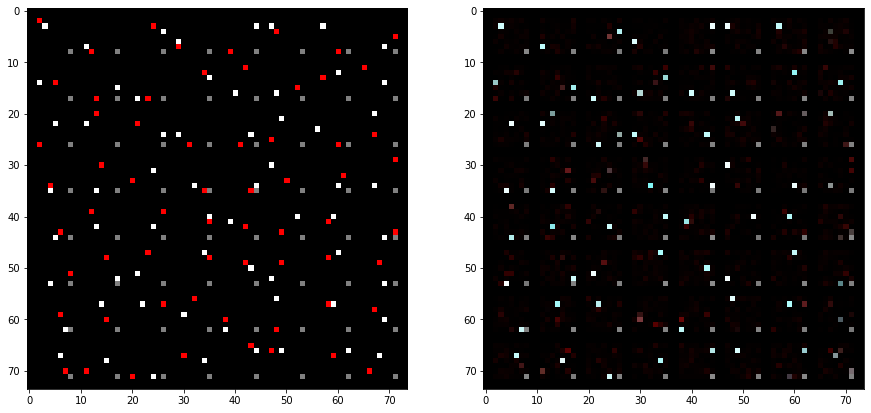

In [223]:
print('xavier')
vae.eval()
with torch.no_grad():
    out_recon = vae(x_train.to(device))
    in_grid = torchvision.utils.make_grid(x_train.view(-1, in_channels, img_size[1], img_size[0]).cpu())
    out_grid = torchvision.utils.make_grid(out_recon['z_mu'].view(-1, in_channels, img_size[1], img_size[0]).cpu())

fig, ax = plt.subplots(ncols=2, figsize=(15,8))
ax[0].imshow(np.transpose(in_grid, (1,2,0)))
ax[1].imshow(np.transpose(out_grid, (1,2,0)))
plt.show()

xavier, beta=0


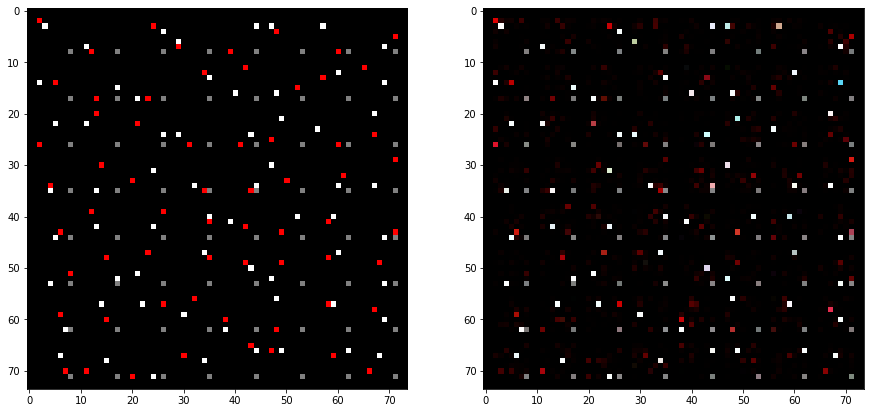

In [236]:
print('xavier, beta=0')
vae.eval()
with torch.no_grad():
    out_recon = vae(x_train.to(device))
    in_grid = torchvision.utils.make_grid(x_train.view(-1, in_channels, img_size[1], img_size[0]).cpu())
    out_grid = torchvision.utils.make_grid(out_recon['z_mu'].view(-1, in_channels, img_size[1], img_size[0]).cpu())

fig, ax = plt.subplots(ncols=2, figsize=(15,8))
ax[0].imshow(np.transpose(in_grid, (1,2,0)))
ax[1].imshow(np.transpose(out_grid, (1,2,0)))
plt.show()

beta=0


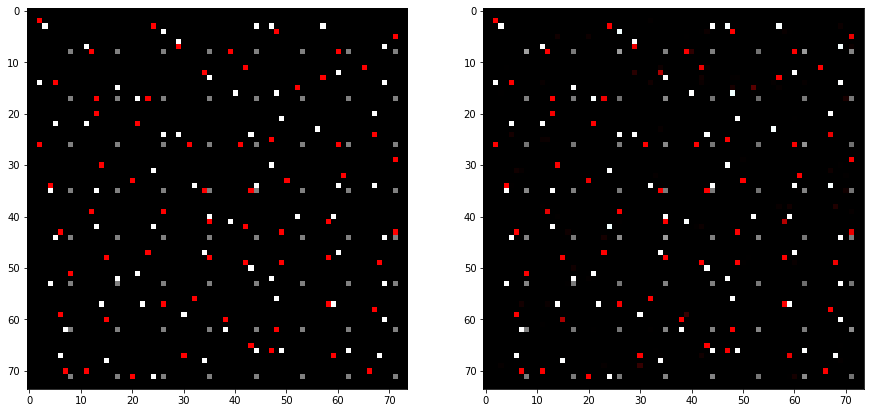

In [240]:
print('beta=0')
vae.eval()
with torch.no_grad():
    out_recon = vae(x_train.to(device))
    in_grid = torchvision.utils.make_grid(x_train.view(-1, in_channels, img_size[1], img_size[0]).cpu())
    out_grid = torchvision.utils.make_grid(out_recon['z_mu'].view(-1, in_channels, img_size[1], img_size[0]).cpu())

fig, ax = plt.subplots(ncols=2, figsize=(15,8))
ax[0].imshow(np.transpose(in_grid, (1,2,0)))
ax[1].imshow(np.transpose(out_grid, (1,2,0)))
plt.show()

# Test Interpolation

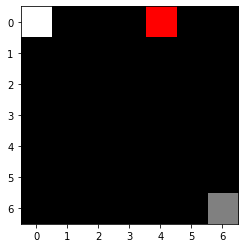

In [11]:
# out_recon['z_mu'].min()
# x_train[0]
# plt.imshow(np.transpose(x_train[0], (1,2,0)))
img_base = '/home/lukas/Workspaces/DTU/deep-rl-thesis/algorithms/data/Gridworlds/moving_water/7x7/interpolation'
img_1 = cv2.imread(img_base + '/a0-0_w0-4.png')
img_2 = cv2.imread(img_base + '/a0-0_w6-4.png')
img_3 = cv2.imread(img_base + '/a1-0_w4-2.png')
img_4 = cv2.imread(img_base + '/a1-6_w4-2.png')
transform = transforms.ToTensor()
x_1 = transform(img_1).to(device)
x_2 = transform(img_2).to(device)
x_3 = transform(img_3).to(device)
x_4 = transform(img_4).to(device)
plt.imshow(img_1)

beta=0


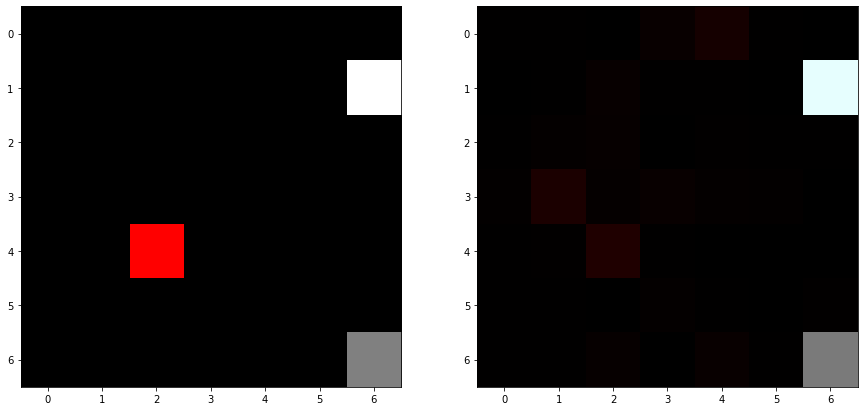

In [24]:
print('beta=0')
vae.eval()
with torch.no_grad():
    x_in = x_4
    out_recon = vae(x_in.unsqueeze(0))
    in_grid = torchvision.utils.make_grid(x_in.view(-1, in_channels, img_size[1], img_size[0]).cpu())
    out_grid = torchvision.utils.make_grid(out_recon['z_mu'].view(-1, in_channels, img_size[1], img_size[0]).cpu())

fig, ax = plt.subplots(ncols=2, figsize=(15,8))
ax[0].imshow(np.transpose(in_grid, (1,2,0)))
ax[1].imshow(np.transpose(out_grid, (1,2,0)))
plt.show()

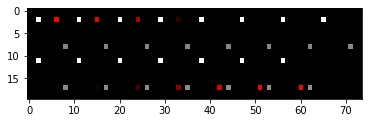

In [276]:
linspace = latent_interpolation(x_1, x_2)

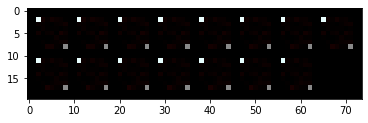

In [286]:
linspace = latent_interpolation(x_1, x_2)

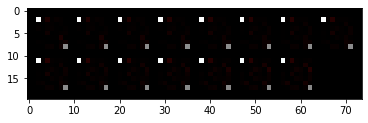

In [26]:
linspace = latent_interpolation(x_1, x_2)

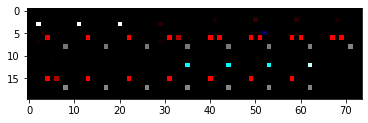

In [277]:
linspace = latent_interpolation(x_3, x_4)

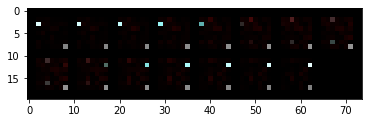

In [287]:
linspace = latent_interpolation(x_3, x_4)

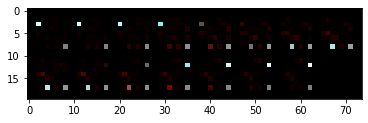

In [27]:
linspace = latent_interpolation(x_3, x_4)

In [25]:
def latent_interpolation(x_1, x_2, num=15):
    vae.eval()
    with torch.no_grad():
#         z_1_mu, z_1_logvar = vae.encoder(np.transpose(x_1, (2, 0, 1)).unsqueeze(0))
#         z_2_mu, z_2_logvar = vae.encoder(np.transpose(x_2, (2, 0, 1)).unsqueeze(0))
        z_1_mu, z_1_logvar = vae.encoder(x_1.unsqueeze(0))
        z_2_mu, z_2_logvar = vae.encoder(x_2.unsqueeze(0))
        z_linspace = np.linspace(z_1_mu, z_2_mu, num=num)
        interpolation_recon = vae.decoder(torch.from_numpy(z_linspace).to(device))
        
    out_grid = torchvision.utils.make_grid(interpolation_recon)
    plt.imshow(np.transpose(out_grid, (1,2,0)))
    plt.show()
    return z_linspace

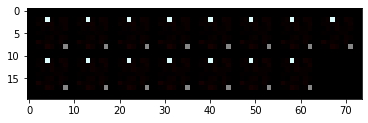

In [188]:
_ = latent_interpolation(a02_w30, a02_w35)

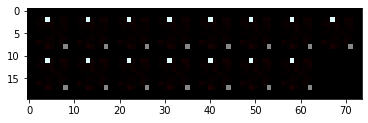

(15, 1, 10)

In [185]:
z_2_mu = latent_interpolation(a02_w30, a62_w04)
z_2_mu.shape

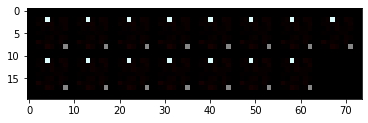

In [164]:
# fig, ax = plt.subplots(ncols=15, figsize=(20,5))
# for i in range(15):
#     img = np.transpose(w30_w35_recon_out[i], (1,2,0))
#     ax[i].imshow(img)
out_grid = torchvision.utils.make_grid(w30_w35_recon_out)
plt.imshow(np.transpose(out_grid, (1,2,0)))
plt.show()
# w30_w35_recon_out.shape

In [154]:
# Record latent space interpolations
n = 15
with torch.no_grad():
    latent_space = torch.zeros((n*args.latent_dim, args.latent_dim))
    for i in range(args.latent_dim):
        latent_space[i*n:(i+1)*n, i] = torch.from_numpy(np.linspace(-3, 3, n))
    # print(latent_space)
#     recon_out = vae.decoder(latent_space.to(device))
#     grid = torchvision.utils.make_grid(recon_out.view(-1, in_channels, img_size[1], img_size[0]).cpu(), nrow=n)
latent_space.shape

torch.Size([150, 10])